In [1]:
import xarray as xr
from pathlib import Path
import glob

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()

In [22]:
cluster.scale(30) 

In [32]:
from dask.distributed import performance_report, Client
client = Client(cluster)

In [33]:
client

Client Scheduler: tcp://10.148.1.123:48176 Dashboard: /user/todaka/proxy/8787/status,Cluster Workers: 28 Cores: 28 Memory: 120.12 GB


In [34]:
!qstat -u todaka -n


datarmor0: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
8738973.datarmo todaka   ice_mt   jupyterhub  35621   1   8   16gb 02:00 R 01:05
   r2i2n25/1*8
8739239.datarmo todaka   mpi_1    wo          10003   1  28  120gb 24:00 R 00:03
   r2i0n34/0*28
8739243.datarmo todaka   mpi_1    wo          34387   1  28  120gb 24:00 R 00:01
   r2i1n15/0*28


**pb on datarmor; cant increase more than 1 full node as a workers /does not connect... 

## Copy real netcdf Data from datalake

On datarmor compute node, i can't access internet/(can not access to synthetic data example) thus used real data available on datalake.
/home/ref-oc-public/modeles_marc/f1_e4000/best_estimate/2014/MARC_F1-MARS3D-MANGAE4000_2014123120*Z.nc
These are hourly netcdf computed output.

Let's create a tarbar for the created netCDF files

In [35]:
!fusermount -u mounted_dataset
!rm -rf data mounted_dataset
!mkdir -p data/realdata
!cp  /home/ref-oc-public/modeles_marc/f1_e4000/best_estimate/2014/MARC_F1-MARS3D-MANGAE4000_2014*01T2300Z.nc data/realdata/.
!tar Pcf data/realdata.tar data/realdata/*

In [36]:
#prepare test GPFS
!fusermount -u ${DATAWORK}/xtar/mounted_dataset
!rm -rf ${DATAWORK}/xtar data_gpfs
!mkdir -p ${DATAWORK}/xtar
!ln -sf ${DATAWORK}/xtar data_gpfs
!cp -R data/realdata* data_gpfs/.

In [37]:
#prepare test Lustre
!fusermount -u ${SCRTACH}/xtar/mounted_dataset
!rm -rf ${SCRATCH}/xtar data_lustre
!mkdir -p ${SCRATCH}/xtar
!ln -sf ${SCRATCH}/xtar data_lustre
!cp -R data/realdata* data_lustre/.

fusermount: bad mount point /xtar/mounted_dataset: No such file or directory
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc’: Read-only file system
rm: cannot remove ‘/home1/scratch/todaka/xtar/mounted_datas

## ratarmount

We will use [ratarmount](https://github.com/mxmlnkn/ratarmount) to create an index file with file names, ownership, permission flags, and offset information to be stored at the TAR file's location. Once the index is created, ratarmount then offers a FUSE mount integration for easy access to the files.

**NOTE:** Since `ratarmount` uses FUSE to mount the TAR file as a "filesystem in user space", you will need FUSE installed.  On OSX, you will need to install [osxfuse](https://osxfuse.github.io/) *by hand*.  On Linux, you can install `libfuse` using `conda`, if it is not already installed on your system.

**NOTE:** If you have `libfuse` on your system and it is *older* than October 19, 2018 (i.e., < 3.3.0 for `fuse3` or < 2.9.9 for `fuse2`), and you have either Lustre or GPFS filesystems, `ratarmount` will fail with an error saying that your filesystem is unsupported.  The solution is to upgrade to a newer version of `libfuse`.

**NOTE:** If you install the `libfuse` Conda-Forge package on a Linux system, then you need to set the `FUSE_LIBRARY_PATH` environment variable to the location of the `libfuse.so` library file (e.g., `export FUSE_LIBRARY_PATH=/path/to/libfuse3.so`).  If you do not do this, then `fusepy` (another dependency of `ratarmount`) will use the system `libfuse.so` file, which might be old.

**NOTE:** Currently, the Conda-Forge version of `libfuse` does *not* build the `libfuse` utilities such as `fusermount3`.  However, `fusepy` uses these utility functions under the hood when trying to mount the userspace filesystem.  If you install the most recent version of `libfuse` and properly set the location of `libfuse` so that `fusepy` can find it (i.e., `FUSE_LIBRARY_PATH`), you will get an error the `fusermount3` cannot be found.

In [13]:
%%time
!/home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index data/realdata.tar mounted_dataset
!ssh r2i0n34 /home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index ${HOME}/git/xtar/notebooks/data/realdata.tar ${HOME}/git/xtar/notebooks/mounted_dataset

Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data/realdata.tar ...
Creating new SQLite index database at /home1/datahome/todaka/git/xtar/notebooks/data/realdata.tar.index.sqlite
Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data/realdata.tar took 0.01s
Writing out TAR index to /home1/datahome/todaka/git/xtar/notebooks/data/realdata.tar.index.sqlite took 0s and is sized 24576 B
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 344 ms


In [31]:
%%time
#test GPFS
!/home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index data_gpfs/realdata.tar data_gpfs/mounted_dataset

!ssh r2i0n34 /home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index ${HOME}/git/xtar/notebooks/data_gpfs/realdata.tar ${HOME}/git/xtar/notebooks/data_gpfs/mounted_dataset

Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data_gpfs/realdata.tar ...
Creating new SQLite index database at /home1/datahome/todaka/git/xtar/notebooks/data_gpfs/realdata.tar.index.sqlite
Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data_gpfs/realdata.tar took 0.65s
Writing out TAR index to /home1/datahome/todaka/git/xtar/notebooks/data_gpfs/realdata.tar.index.sqlite took 0s and is sized 24576 B
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
Traceback (most recent call last):
  File "/home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount", line 8, in <module>
    sys.exit(cli())
  File "/home1/datahome/todaka/conda-env/xtar-dev/lib/python3.8/site-packages/ratarmount.py", line 1537, in cli
    fuse.FUSE( operations = fuseOperationsObject,
  File "/home1/datahome/todaka/conda-env/xtar-dev/lib/python3.8/site-packages/fuse.py", line 711, in __init__
    raise RuntimeError(err)
Runti

In [32]:
%%time
#test Lustre
!/home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index data_lustre/realdata.tar data_lustre/mounted_dataset
!ssh r2i0n34 /home1/datahome/todaka/conda-env/xtar-dev/bin/ratarmount --recreate-index ${HOME}/git/xtar/notebooks/data_lustre/realdata.tar ${HOME}/git/xtar/notebooks/data_lustre/mounted_dataset

Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data_lustre/realdata.tar ...
Creating new SQLite index database at /home1/datahome/todaka/git/xtar/notebooks/data_lustre/realdata.tar.index.sqlite
Creating offset dictionary for /home1/datahome/todaka/git/xtar/notebooks/data_lustre/realdata.tar took 0.01s
Writing out TAR index to /home1/datahome/todaka/git/xtar/notebooks/data_lustre/realdata.tar.index.sqlite took 0s and is sized 24576 B
CPU times: user 84 ms, sys: 40 ms, total: 124 ms
Wall time: 1.02 s


For comparison, this is how long it takes to `list` the original data directory.

In [33]:
%%time
mounted_dir = Path("mounted_dataset/data/realdata/")
list(mounted_dir.iterdir())

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 875 µs


[PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140701T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140801T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140901T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20141001T2300Z.nc'),
 PosixPath('mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20141101T2300Z.nc'),
 PosixPath('mounted_d

**NFS=> tar 1.07 ms  real file 1.18ms

In [34]:
%%time
mounted_dir = Path("data_gpfs/mounted_dataset/data/realdata/")
list(mounted_dir.iterdir())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.37 ms


[PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140701T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140801T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140901T2300Z.nc'),
 PosixPath('data_gpfs/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20141001T2300Z.nc'),
 PosixPath

In [35]:
%%time
mounted_dir = Path("data_gpfs/realdata/")
list(mounted_dir.iterdir())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.01 ms


[PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140801T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20141201T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140901T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20141001T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20140701T2300Z.nc'),
 PosixPath('data_gpfs/realdata/MARC_F1-MARS3D-MANGAE4000_20141101T2300Z.nc')]

**GPFS=> tar 1.31 ms  real file 853 µs


In [36]:
%%time
mounted_dir = Path("data_lustre/mounted_dataset/data/realdata/")
list(mounted_dir.iterdir())

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.26 ms


[PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140701T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140801T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20140901T2300Z.nc'),
 PosixPath('data_lustre/mounted_dataset/data/realdata/MARC_F1-MARS3D-MANGAE4000_20141001T23

In [37]:
%%time
mounted_dir = Path("data_lustre/realdata/")
list(mounted_dir.iterdir())

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 950 µs


[PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20141001T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20141101T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140101T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140401T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140701T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140801T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140601T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140201T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140901T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140501T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20140301T2300Z.nc'),
 PosixPath('data_lustre/realdata/MARC_F1-MARS3D-MANGAE4000_20141201T2300Z.nc')]

**LUSTRE=> tar 1.18 ms  real file 925 µs

**slightly  slower to list the directory contents 

Following test not yet done on datarmor

## Benchmarks

In [18]:

client

Client Scheduler: tcp://10.148.1.123:43108 Dashboard: /user/todaka/proxy/8787/status,Cluster Workers: 28 Cores: 28 Memory: 120.12 GB


### Original netCDF files

In [19]:
ds_orig = xr.open_mfdataset("data/realdata/*.nc", combine='nested', concat_dim='member_id')
ds_orig

<xarray.Dataset>
Dimensions:      (level: 30, member_id: 12, ni: 515, ni_f: 515, ni_u: 515, ni_v: 515, nj: 391, nj_f: 391, nj_u: 391, nj_v: 391, time: 12)
Coordinates:
    longitude    (nj, ni) float64 dask.array<chunksize=(391, 515), meta=np.ndarray>
    longitude_u  (nj_u, ni_u) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude     (nj, ni) float64 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude_v   (nj_v, ni_v) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    longitude_v  (nj_v, ni_v) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude_u   (nj_u, ni_u) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_f         (ni_f) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * time         (time) datetime64[ns] 2014-01-01T23:00:00 ... 2014-12-01T23:00:00
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * level        (level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
Dimensions without coordinates: member_id
Data variables:
    SIG          (member_id, level) float32 dask.array<chunksize=(1, 30), meta=np.ndarray>
    Csu_sig      (member_id, level) float32 dask.array<chunksize=(1, 30), meta=np.ndarray>
    hc           (member_id, nj, ni) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    b            (member_id) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    theta        (member_id) float64 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    H0           (member_id, nj, ni) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    HX           (member_id, nj_u, ni_u) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    HY           (member_id, nj_v, ni_v) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    XE           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 12, 391, 515), meta=np.ndarray>
    UZ           (member_id, time, level, nj_u, ni_u) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    VZ           (member_id, time, level, nj_v, ni_v) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    SAL          (member_id, time, level, nj, ni) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    TEMP         (member_id, time, level, nj, ni) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
Attributes:
    limi:                    0
    lima:                    514
    pasi:                    1
    ljmi:                    0
    ljma:                    390
    pasj:                    1
    lkmi:                    1
    lkma:                    30
    pask:                    1
    global_imin:             0
    global_imax:             514
    global_jmin:             0
    global_jmax:             390
    data_type:               OCO oriented grid
    format_version:          1.3.1
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    netcdf_version:          4.1.2
    product_version:         1.0
    references:              http://www.previmer.org/
    easting:                 longitude
    northing:                latitude
    grid_projection:         n/a
    distribution_statement:  Data restrictions: for registered users only
    institution:             IFREMER
    institution_references:  http://www.ifremer.fr/
    data_centre:             IFREMER OCO DATA CENTER
    data_centre_references:  http://www.previmer.org/
    creation_date:           2014-01-03T13:29:49Z
    run_ti

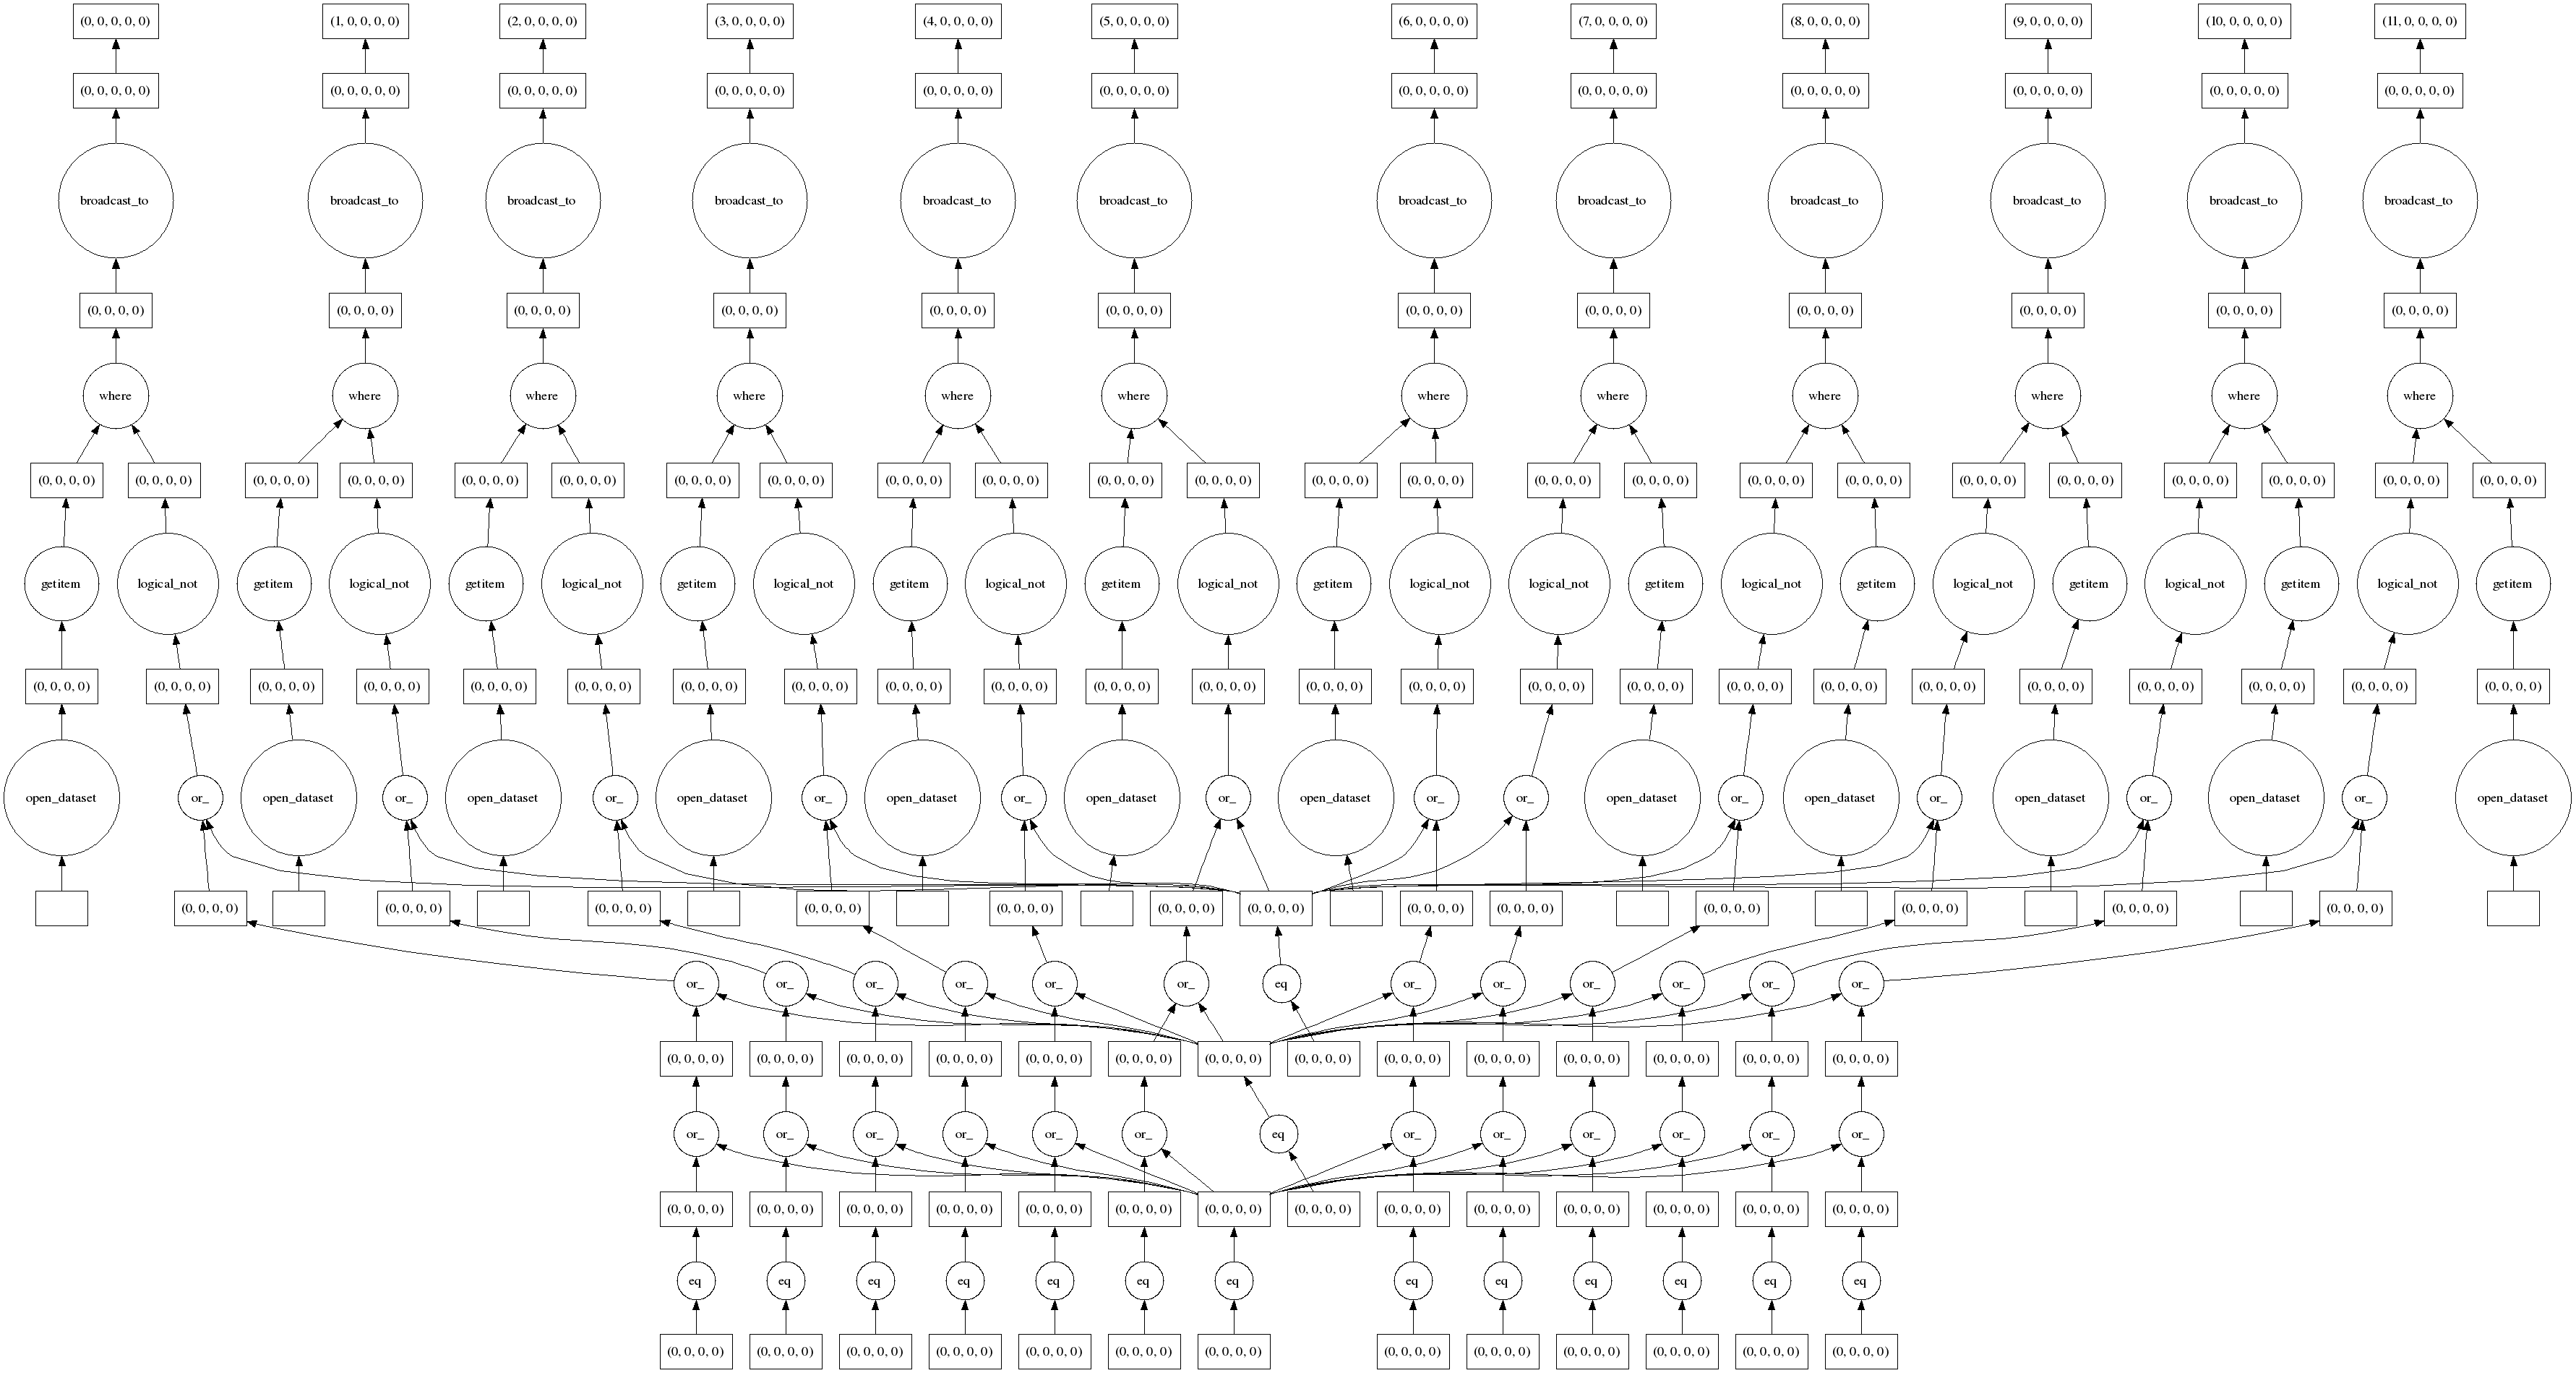

In [20]:
ds_orig.TEMP.data.visualize()

### Mounted netCDF files from the tar archive

In [21]:
ds_mntd = xr.open_mfdataset("mounted_dataset/data/realdata/*.nc", combine='nested', concat_dim='member_id')
ds_mntd

<xarray.Dataset>
Dimensions:      (level: 30, member_id: 12, ni: 515, ni_f: 515, ni_u: 515, ni_v: 515, nj: 391, nj_f: 391, nj_u: 391, nj_v: 391, time: 12)
Coordinates:
    longitude    (nj, ni) float64 dask.array<chunksize=(391, 515), meta=np.ndarray>
    longitude_u  (nj_u, ni_u) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude     (nj, ni) float64 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude_v   (nj_v, ni_v) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    longitude_v  (nj_v, ni_v) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
    latitude_u   (nj_u, ni_u) float32 dask.array<chunksize=(391, 515), meta=np.ndarray>
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_f         (ni_f) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * time         (time) datetime64[ns] 2014-01-01T23:00:00 ... 2014-12-01T23:00:00
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * level        (level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
Dimensions without coordinates: member_id
Data variables:
    SIG          (member_id, level) float32 dask.array<chunksize=(1, 30), meta=np.ndarray>
    Csu_sig      (member_id, level) float32 dask.array<chunksize=(1, 30), meta=np.ndarray>
    hc           (member_id, nj, ni) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    b            (member_id) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    theta        (member_id) float64 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    H0           (member_id, nj, ni) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    HX           (member_id, nj_u, ni_u) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    HY           (member_id, nj_v, ni_v) float32 dask.array<chunksize=(1, 391, 515), meta=np.ndarray>
    XE           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 12, 391, 515), meta=np.ndarray>
    UZ           (member_id, time, level, nj_u, ni_u) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    VZ           (member_id, time, level, nj_v, ni_v) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    SAL          (member_id, time, level, nj, ni) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
    TEMP         (member_id, time, level, nj, ni) float32 dask.array<chunksize=(1, 12, 30, 391, 515), meta=np.ndarray>
Attributes:
    limi:                    0
    lima:                    514
    pasi:                    1
    ljmi:                    0
    ljma:                    390
    pasj:                    1
    lkmi:                    1
    lkma:                    30
    pask:                    1
    global_imin:             0
    global_imax:             514
    global_jmin:             0
    global_jmax:             390
    data_type:               OCO oriented grid
    format_version:          1.3.1
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    netcdf_version:          4.1.2
    product_version:         1.0
    references:              http://www.previmer.org/
    easting:                 longitude
    northing:                latitude
    grid_projection:         n/a
    distribution_statement:  Data restrictions: for registered users only
    institution:             IFREMER
    institution_references:  http://www.ifremer.fr/
    data_centre:             IFREMER OCO DATA CENTER
    data_centre_references:  http://www.previmer.org/
    creation_date:           2014-01-03T13:29:49Z
    run_ti

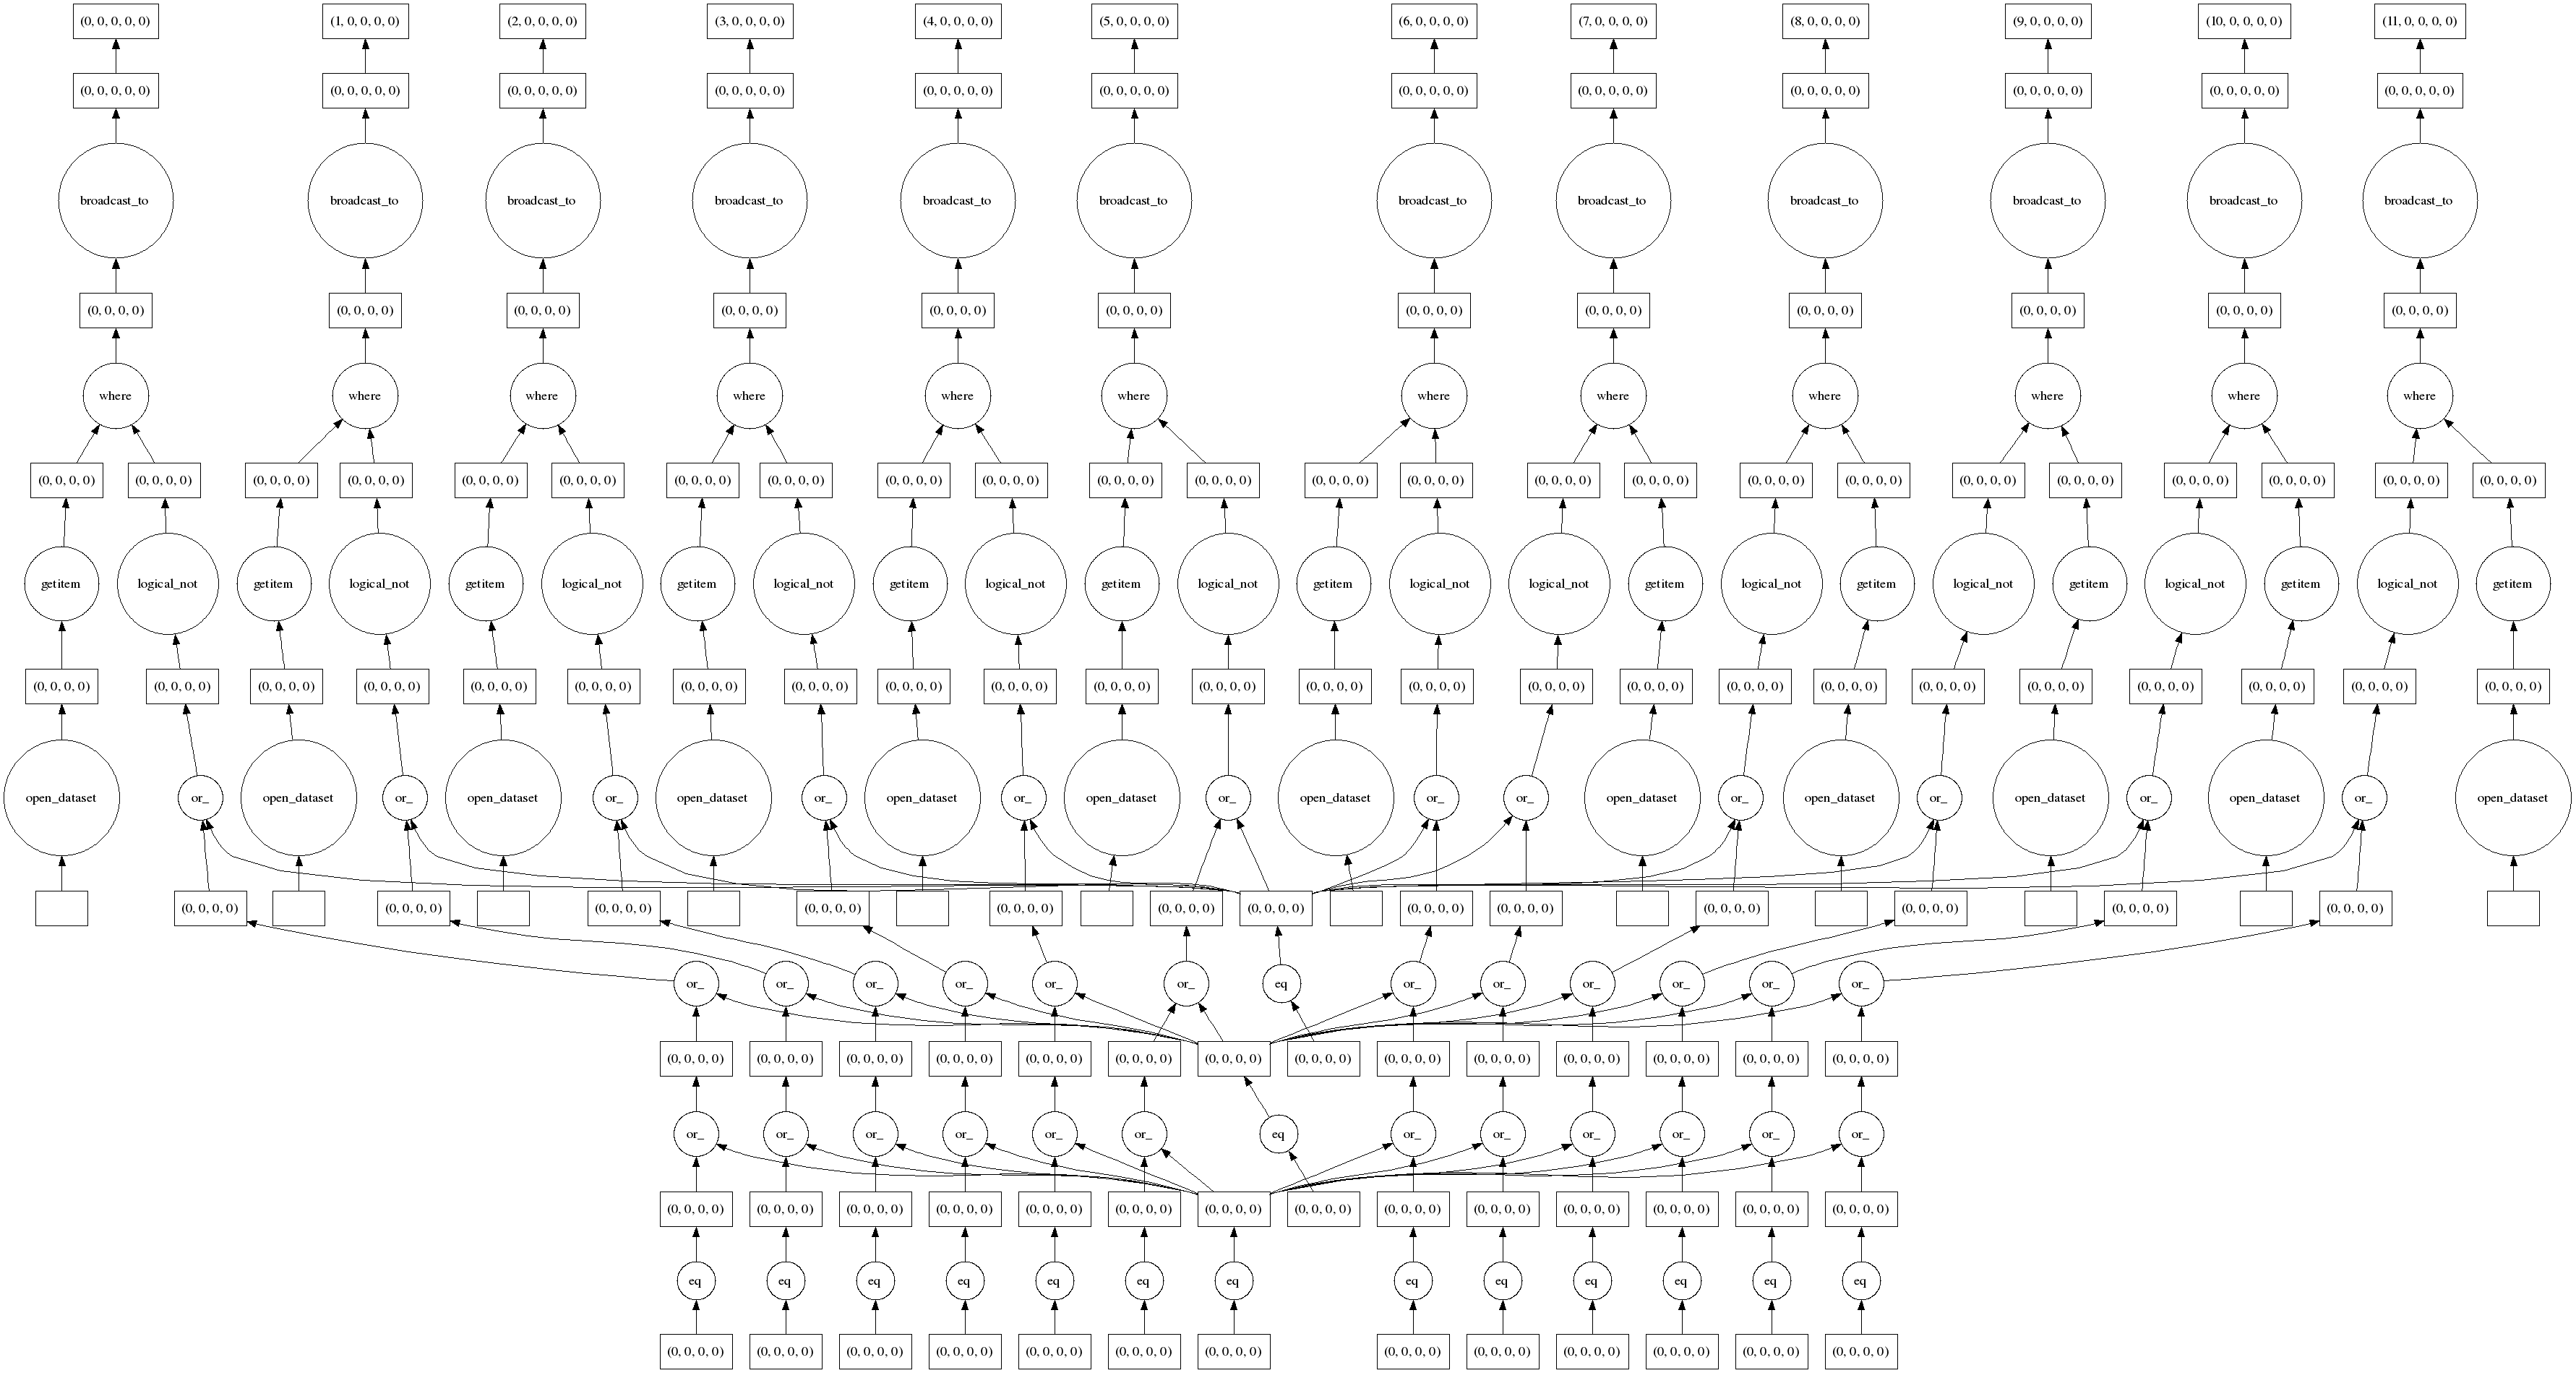

In [22]:
ds_mntd.TEMP.data.visualize()

### Benchmark: Yearly Averages

In [23]:
%%time
ds_orig.groupby('time.year').mean(['time', 'member_id']).compute()

CPU times: user 4.38 s, sys: 772 ms, total: 5.15 s
Wall time: 42.8 s


<xarray.Dataset>
Dimensions:      (level: 30, ni: 515, ni_f: 515, ni_u: 515, ni_v: 515, nj: 391, nj_f: 391, nj_u: 391, nj_v: 391, year: 1)
Coordinates:
    longitude    (nj, ni) float64 -18.05 -18.0 -17.95 -17.89 ... 9.393 9.446 9.5
    longitude_u  (nj_u, ni_u) float32 -18.029114 -17.974182 ... 9.525437
    latitude     (nj, ni) float64 40.96 40.96 40.96 40.96 ... 55.0 55.0 55.0
    latitude_v   (nj_v, ni_v) float32 40.983 40.983 ... 55.018463 55.018463
    longitude_v  (nj_v, ni_v) float32 -18.051088 -18.001648 ... 9.44853 9.497971
    latitude_u   (nj_u, ni_u) float32 40.963776 40.963776 ... 54.999237
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_f         (ni_f) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * level        (level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * year         (year) int64 2014
Data variables:
    SIG          (year, level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
    Csu_sig      (year, level) float32 -0.90483636 -0.7408144 ... -0.0004965802
    hc           (year, nj, ni) float32 150.00336 150.00336 ... nan nan
    b            (year) float64 0.0
    theta        (year) float64 6.0
    H0           (year, nj, ni) float32 5215.4614 5219.142 5245.059 ... nan nan
    HX           (year, nj_u, ni_u) float32 5217.302 5232.1772 ... nan nan
    HY           (year, nj_v, ni_v) float32 5217.302 5219.142 ... nan nan
    XE           (year, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    UZ           (year, level, nj_u, ni_u) float32 nan nan nan ... nan nan nan
    VZ           (year, level, nj_v, ni_v) float32 nan 0.0 ... nan nan
    SAL          (year, level, nj, ni) float32 nan nan nan nan ... nan nan nan
    TEMP         (year, level, nj, ni) float32 nan nan nan nan ... nan nan nan

In [24]:
%%time
ds_mntd.groupby('time.year').mean(['time', 'member_id']).compute()

CPU times: user 1.98 s, sys: 364 ms, total: 2.34 s
Wall time: 10.1 s


<xarray.Dataset>
Dimensions:      (level: 30, ni: 515, ni_f: 515, ni_u: 515, ni_v: 515, nj: 391, nj_f: 391, nj_u: 391, nj_v: 391, year: 1)
Coordinates:
    longitude    (nj, ni) float64 -18.05 -18.0 -17.95 -17.89 ... 9.393 9.446 9.5
    longitude_u  (nj_u, ni_u) float32 -18.029114 -17.974182 ... 9.525437
    latitude     (nj, ni) float64 40.96 40.96 40.96 40.96 ... 55.0 55.0 55.0
    latitude_v   (nj_v, ni_v) float32 40.983 40.983 ... 55.018463 55.018463
    longitude_v  (nj_v, ni_v) float32 -18.051088 -18.001648 ... 9.44853 9.497971
    latitude_u   (nj_u, ni_u) float32 40.963776 40.963776 ... 54.999237
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_f         (ni_f) float32 0.5 1.5 2.5 3.5 4.5 ... 511.5 512.5 513.5 514.5
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 387.5 388.5 389.5 390.5
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * level        (level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 511.0 512.0 513.0 514.0
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 387.0 388.0 389.0 390.0
  * year         (year) int64 2014
Data variables:
    SIG          (year, level) float32 -0.98333335 -0.95 ... -0.05 -0.016666668
    Csu_sig      (year, level) float32 -0.90483636 -0.7408144 ... -0.0004965802
    hc           (year, nj, ni) float32 150.00336 150.00336 ... nan nan
    b            (year) float64 0.0
    theta        (year) float64 6.0
    H0           (year, nj, ni) float32 5215.4614 5219.142 5245.059 ... nan nan
    HX           (year, nj_u, ni_u) float32 5217.302 5232.1772 ... nan nan
    HY           (year, nj_v, ni_v) float32 5217.302 5219.142 ... nan nan
    XE           (year, nj, ni) float32 nan nan nan nan nan ... nan nan nan nan
    UZ           (year, level, nj_u, ni_u) float32 nan nan nan ... nan nan nan
    VZ           (year, level, nj_v, ni_v) float32 nan 0.0 ... nan nan
    SAL          (year, level, nj, ni) float32 nan nan nan nan ... nan nan nan
    TEMP         (year, level, nj, ni) float32 nan nan nan nan ... nan nan nan

### Dask Performance Reports

In [25]:
with performance_report(filename="dask-perf-report-original.html"):
    ds_orig.groupby('time.year').mean(['time', 'member_id']).compute()

In [26]:
with performance_report(filename="dask-perf-report-mounted.html"):
    ds_mntd.groupby('time.year').mean(['time', 'member_id']).compute()

In [27]:
from IPython.display import HTML

In [28]:
display(HTML("dask-perf-report-original.html"))

In [29]:
display(HTML("dask-perf-report-mounted.html"))